# [IAPR][iapr]: Lab 2 ‒  Object description


**Group ID:** 26

**Author 1 (sciper):** Andrea Oliveri (283506)  
**Author 2 (sciper):** Charles Berger (272018)   
**Author 3 (sciper):** Chun Hei Michael Chan (311722)  

**Release date:** 26.03.2021  
**Due date:** 23.04.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

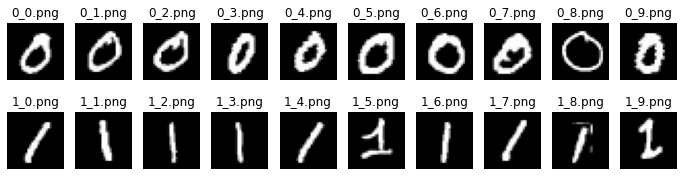

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')


# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors (15 pts)

In [3]:
import cv2 as cv
import numpy as np

def get_fourier_descriptor(image, n_coefficients_to_keep = 2):
    
    # Compute outer contours of image.
    _, contour, _ = cv.findContours(image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    contour = contour[0].squeeze()
    
    # Make complex signal from contour array.
    complex_contour_signal = contour[:, 0] + 1j * contour[:, 1]
    
    # Compute fourier coefficients.
    fourier_coefficients = np.fft.fft(complex_contour_signal)
    
    # To make fourier coefficient resistant to scaling, ratio between coefficients is used instead of actual magnitude.
    fourier_coefficients = fourier_coefficients / fourier_coefficients[0]  
    
    # To make fourier coefficient resistant to translation, first coefficient discarded.
    fourier_coefficients = fourier_coefficients[1:]
    
    # To make fourier coefficient resistant to rotation, phase is discarded.
    fourier_coefficients = np.abs(fourier_coefficients)  
    
    return fourier_coefficients[:n_coefficients_to_keep]


def pretreat_image(image):
    image_uniform_background = image.copy()
    image_uniform_background[image <= 50] = 0
    image_denoised = cv.medianBlur(image_uniform_background, 3)

    return image_denoised


def plot_fourier_descriptors(coefficients_digits_list, marker_digits_list, label_digits_list):
    assert(len(coefficients_digits_list) == len(marker_digits_list) == len(label_digits_list))
    
    for coefficients_digit, marker, label in zip(coefficients_digits_list, marker_digits_list, label_digits_list):
        plt.scatter(coefficients_digit[:, 0], coefficients_digit[:, 1], marker = marker, label = label)
        
    plt.legend()
    plt.show()

In [4]:
coefficients_zeros = np.asarray([get_fourier_descriptor(pretreat_image(im)) for im in zeros_im])
coefficients_ones  = np.asarray([get_fourier_descriptor(pretreat_image(im)) for im in ones_im])

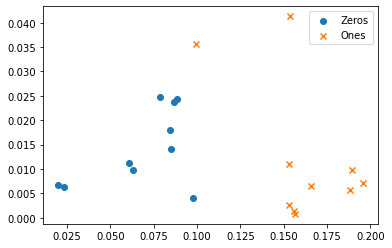

In [5]:
plot_fourier_descriptors([coefficients_zeros, coefficients_ones], ['o', 'x'], ["Zeros", "Ones"])

<b>Invariances</b>
 
<i> quick note: we mentioned doing mean of image to then span sample from it but it might not be a very good mean image, might require more than just averaging the intensities across images. So instead we will span a sample out of the 10 images. We will be picking one, transforming it, then adding it to the sample.

AssertionError: 

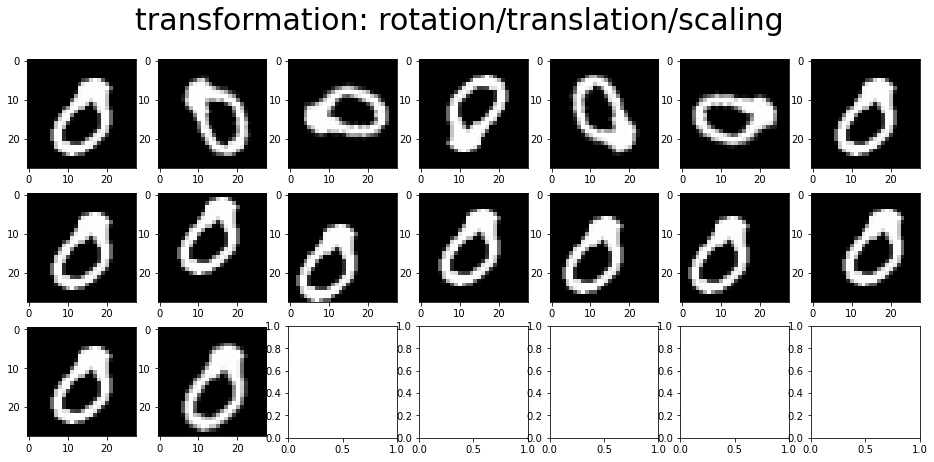

In [6]:
# to check invariance we implement functions 
# (that we will use throughout exercises ->Fourier descriptor and additional method) 
# https://opencv-python-tutroals.readthedocs.io/en/latest/-
# -py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
# that rotate/scale/translate

# indeed we have some loss pixel wise some quick link below, but I don't think 
# we can totally fix this issue
# https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/
def rotate(img, deg):
    """
    desc: rotate object (technically here we rotate the whole 
    image with center of image being center of rotation, but 
    since background thresholded)
    """
    rows, cols = img.shape
    matrix = cv.getRotationMatrix2D((cols/2, rows/2), deg, 1)
    result = cv.warpAffine(img, matrix, (cols,rows), flags = cv.INTER_CUBIC)

    return result
    
def translate(img, dx, dy):
    """
    desc: translate object by translating full image
    """
    rows, cols = img.shape
    matrix = np.float32([[1, 0, dx], [0, 1, dy]])
    result = cv.warpAffine(img, matrix, (cols, rows))
    
    assert np.sum(img>0) == np.sum(result>0)
    return result 

def scale(img, vertical_factor, horizontal_factor):
    """
    desc: scaling object by scaling full image
    """
    # note: INTER_CUBIC better for upsample
    # for downsample might be better to use INTER_AREA
    rows, cols = img.shape
    scaled = cv.resize(img, None, fy = vertical_factor, fx = horizontal_factor, interpolation = cv.INTER_CUBIC)
    new_rows, new_cols = scaled.shape
    crop = scaled[(new_rows - rows) // 2:(new_rows + rows) // 2, (new_cols - cols) // 2:(new_cols + cols) // 2]
    
    assert np.sum(scaled>0) == np.sum(crop>0)
    return crop

# testing here
fig,ax = plt.subplots(3,7,figsize=(16,7))
fig.suptitle("transformation: rotation/translation/scaling",fontsize=30)
test = zeros_im[0]

# rotations
ang = np.linspace(0,360,7)
for i in range(7):
    r = rotate(test,ang[i])
    ax[0,i].imshow(r,cmap='gray')

# translations 
shiftx = np.pad(np.random.randint(-4,4,6),1,'constant')[:-1]
shifty = np.pad(np.random.randint(-4,4,6),1,'constant')[:-1]
for i in range(7):
    dx,dy = shiftx[i],shifty[i]
    t = translate(test,dx,dy)
    ax[1,i].imshow(t,cmap='gray')
    
# scaling 
empmax = (1.65,1.17)
scalex = np.linspace(1,empmax[0],7)
scaley = np.linspace(1,empmax[1],7)
for i in range(7):
    sx,sy = scalex[i],scaley[i]
    s = scale(test,sx,sy)
    ax[2,i].imshow(s,cmap='gray')

plt.tight_layout()
plt.show()

In [7]:
# generate sample 
np.random.seed(10)

def gen_sample(images,n=5):
    """
    desc: generate transformed images for each image in the input
    the transformations include as much rotated/translated/scaled images
    
    PTODO: perhaps combining the transformations e.g rotation -> translation -> output
    """
    #Note: ranges are determined empirically trhu examples for now
    # specific to 0 and 1
    def _rotate(img):
        while True: 
            ang = np.random.randint(0,360)
            try: return rotate(img,ang)
            except: continue
    def _translate(img,rx=10,ry=10):
        while True:
            dx,dy = np.random.randint(-rx,rx), np.random.randint(-ry,ry)
            try: return translate(img,dx,dy)
            except: continue
    #TOFIX: scaling downsize
    def _scale(img,rx=(1,2),ry=(1,1.5)):
        while True:
            sx,sy = np.random.uniform(rx[0],rx[1]), np.random.uniform(ry[0],ry[1])
            try: return scale(img,sx,sy)
            except: continue
    R = []
    T = []
    S = []
    for img in images:
        R += [_rotate(img) for i in range(n)]
        T += [_translate(img) for i in range(n)]
        S += [_scale(img) for i in range(n)]
    
    return R,T,S

In [8]:
R0,T0,S0 = gen_sample(zeros_im)
R1,T1,S1 = gen_sample(ones_im)

F0 = np.asarray(R0+T0+S0+list(zeros_im))
F1 = np.asarray(R1+T1+S1+list(ones_im))

coefficients_zeros = np.asarray([get_fourier_descriptor(pretreat_image(im)) for im in F0])
coefficients_ones  = np.asarray([get_fourier_descriptor(pretreat_image(im)) for im in F1])

#### Discussion
##### Description of the processing : 

- Pre-processing : `pretreat_image() function`
    <br>
   
    - For every image's pixels that have a value below 50 in the image, we put them at 0.
    <br>
    
    - We apply a median filter of size 3 to remove noise (i.e. white pixel that do not belong to the object) while preserving the edge
    <br>


- Processing : `get_fourier_descriptor() and plot_fourier_descriptors()`
    <br>
    
     1. We extract the outer contour of the feature and reduce their dimension with `np.squeeze()`in order to get a 2D vector.
    <br>
    
     2. We make a complex out of the contours coordinates.
    <br>
    
     3. We apply the Fast Fourier Transform (FFT) to get the Fourier Descriptors (FD)
    <br>
    
     4. We make a set of trasnformation of the FD in order to make them invariant to translation, rotation and scaling. Thus, we discarded the 1st FD, take their norms to be insensitive to the phase and finally scale them by the 1st FD.  
    <br>
    
     5. Since we only need at least 2 features, we extract the 2 first FD.
    <br>
    
     6. We verify that we have the same number of labels, markers and Two arrays of FDs from studied images.
    <br>
    
     7. We plot them by assining to an array a specific markers and labels.
    <br>
        
 
- Post-processing : `gen_sample() function` : 
    <br>
    
    - We proove that our FD are translation, rotation and scaling invariant by apply different angle, translation and scaling on the on our image. 
    <br>
    
    - Then we apply `get_fourier_descriptor()`on the image.
    <br>
    
    - Finally, we apply `plot_fourier_descriptors()`. We should get the same results than in the non rotated, non translated and non scaled image.
    <br>
    


##### General comment on method

- Fourier Descriptor method is a fast and efficient way to extract the feature from the objects. We can make good image classification based on only the 2 first image's FDs and make this classification invariant to any type of affine transformation (rotation, translation,scaling,...). Plus, The calculation of the FD is extremely fast and efficient thanks to the FFT.   
    <br/>

- One main issues with the Fourier descriptor methods is the number of FD to keep. In our cases, only 2 FD are enough to get a good feature classification. However, In the second part of the lab (where we have to classified images of 0,1,2 and 3), we see that they are not sufficient. In general, it is difficult to know how many Fourier Descriptor we need to keep in order to get a good descriptions. 


##### Comment on results

- The inter class variance between each features is large enough to extract them.
  <br/>

- The intra class variance is small enough in each features (although we can make it smaller).
  <br/>
  
- Only 2 features (i.e. 2 FD) ae needed to get this classification, so we have a small number of feature.
  <br/>

- The FDs are independent to any type of transformation (scaling, rotation, translation)
  <br/>
  
- `Conclusion`: The Fourier Descriptor method is efficient in classifying images with 0 and 1.


##### Comparison to other methods

- Comparison to Hu Moments :
    <br/>
      
    - For the zero images : The Hu moments give a smaller intra class variance than the Fourier Descriptors. 
    
    <br/>
    
    - For the one images : The Hu moments give a larger intra class variance than the Fourier Descriptors
    
    <br/>
    
    - The inter class variance is larger in the Hu Moments than in the FD. 
  
    <br/>
    
    - Both methods have succeded to classify correctly both images.

##### Improvements and alternative approaches 

- Test other number of features to see if we can extract better the features in the FD methods
  <br/> 


### 1.3 Additional method (5 pts)

<b>Hu moments method</b>

<i>We did no pre-processing yet, we will see what to do later.<i/>

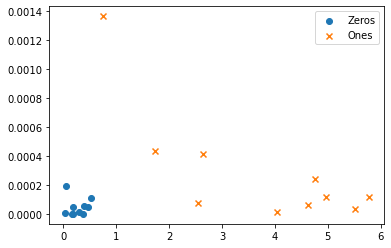

In [9]:
# Add your implementation and discussion
# https://www.pyimagesearch.com/2014/10/27/opencv-shape-descriptor-hu-moments-example/

# Hu Moments 
def feature_ext(img,n=2):
    """
    desc: gives the invariant features of an image 
    """
    m = cv.moments(img)
    return cv.HuMoments(m).flatten()[1:3]

def plot_regiondesc(coefficients_digits_list,marker_digits_list, label_digits_list):
    for coefficients_digit, marker, label in zip(coefficients_digits_list, 
                                                 marker_digits_list, label_digits_list):
        plt.scatter(coefficients_digit[:, 0], coefficients_digit[:, 1], 
                    marker = marker, label = label)
        
    plt.legend()
    plt.show()


zero_features = np.asarray([feature_ext(img) for img in zeros_im])
one_features = np.asarray([feature_ext(img) for img in ones_im])
sample = np.concatenate((zero_features,one_features))
zero_features /= np.mean(sample)
one_features /= np.mean(sample)

plot_regiondesc([zero_features,one_features],['o', 'x'], ["Zeros", "Ones"])

<b> Invariance</b>

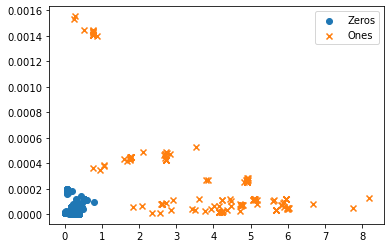

In [10]:
R0,T0,S0 = gen_sample(zeros_im)
R1,T1,S1 = gen_sample(ones_im)

F0 = np.asarray(R0+T0+S0+list(zeros_im))
F1 = np.asarray(R1+T1+S1+list(ones_im))

zero_features = np.asarray([feature_ext(img) for img in F0])
one_features = np.asarray([feature_ext(img) for img in F1])
sample = np.concatenate((zero_features,one_features))
zero_features /= np.mean(sample)
one_features /= np.mean(sample)

plot_regiondesc([zero_features,one_features],['o', 'x'], ["Zeros", "Ones"])

#### Discussion
##### Description of the processing : 

- Pre-processing : 
    <br>
    - Since the Hu moments are already rotation and translation invariante, we only need to make them scale invariant. To do so, we divide every moments by the mean of all moments of zero and one images. 
    
    <br>
    

- Processing : `feature_ext()` and `plot_regiondesc()`
    <br>
    
    1. For both the zero's and one's images, we extract the moment of the image.
    
    <br>
    
    2. We transform the moments into Hu moments (to make them invariant to translation, scale and rotation) and recolte the moments into a 1D array by using the `np.flatten()` function. We only take the 2 first moments (as features).

    <br>
    
    3. by assigning a specific labels and markers to each image's moments, we plot them by using the `plot_regiondesc()` function.


- Post-processing : 
    <br>
    
    - We verify the moment's invariances by applying affine transformation to the images. Then we apply both functions described earlier and see if we get the same results. 


##### General comment on method

- Image's moments correspond to the pixel's repartition of an object in a image. More precisely, it's a weighted average of the mage pixel's intensities that gives informations about the area (or total intensity), the centroid and the orientation of the objects [1]. They can be made invariant to translation (central moments) by centring the x and y values on their means. Plus, by uing Hu moments, moments can be made invariante to translation, rotation and scaling. We get a set of 7 Hu moments, for which the 6 first are reflection symmetric (i.e. they are the same if we take the mirror version of the image) while the 7th one is reflection antisymmetric. Finally, just like the FD methods, we can only select a set of moments to make a classification of the images and extract features.
    <br/>

- However, Hu moments are, first of all, not independent. They can be expressed as a sum of other Hu moments. Secondly, It is not clear which moments (or set of moments) needs to be used in order to get the best image classification and feature extraction. 


##### Comment on results

- The intra class variance is smaller in the zero images than in the one images.
  <br/>

- The inter class variances is extremely large between both images. We have thus a good distinction between images;
  <br/>
  
- Only two moments are needed to get such a good classification. Thus, only two moments seems to be necessary to have good results.

- All the features used are independent to translation, rotation and scaling.

##### Improvements and alternative approaches 

- We need to find the set of moments that gives the best results and separation between images.
  <br/>

- 
  <br/>
  
- 

###### References : 

[1] https://en.wikipedia.org/wiki/Image_moment

https://docs.opencv.org/master/d3/dc0/group__imgproc__shape.html#gab001db45c1f1af6cbdbe64df04c4e944

https://stackoverflow.com/questions/11379947/meaning-of-the-seven-hu-invariant-moments-function-from-opencv
These values are proved to be invariants to the image scale, rotation, and reflection except the seventh one, whose sign is changed by reflection. This invariance is proved with the assumption of infinite image resolution. In case of raster images, the computed Hu invariants for the original and transformed images are a bit different.

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

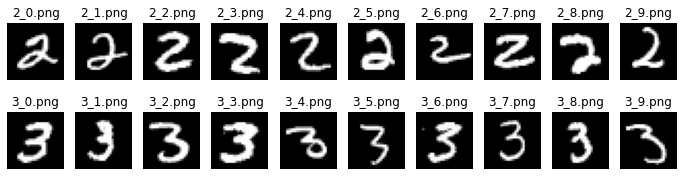

In [11]:
#  Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

In [12]:
coefficients_twos   = np.asarray([get_fourier_descriptor(pretreat_image(im)) for im in twos_im])
coefficients_threes = np.asarray([get_fourier_descriptor(pretreat_image(im)) for im in threes_im])

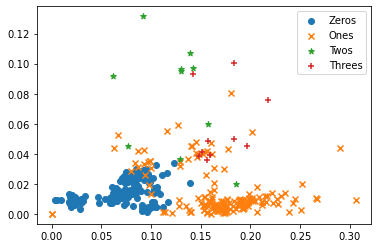

In [13]:
plot_fourier_descriptors([coefficients_zeros, coefficients_ones, coefficients_twos, coefficients_threes], 
                         ['o', 'x', '*', '+'], ["Zeros", "Ones", "Twos", "Threes"])

### Discussion : 

`All the comments and improvements made on the FD descriptors have been done in part 1.`

##### Comment on results

- Although 0 and 1 images are really well separated, we observed that the 2 and 3 images are merging together. We can make a clear distinction between them.

`Conclusion` : 2 features aren't sufficient to make a good classification and feature extraction of the images. We need more features.



##### extra code for testing the auxiliaries (keep in case)

In [ ]:
fig,ax = plt.subplots(1,3)
test = zeros_im[0]
r1 = rotate(test,30,100)
r2 = rotate(r1,-30,100)
ax[0].imshow(test)
ax[1].imshow(r1)
ax[2].imshow(r2)

plt.show()


In [ ]:
plt.imshow(translate(test,4,3))

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(scale(test,1.65,1.17))
ax[1].imshow(test)